# Stock Prediction

#### This project introduces common techniques to manipulate time series and make predictions.
#### The data is a sample from the historical [US stock prices in the last 5 years](https://intrinio.com/bulk-financial-data-downloads/all). Only the New German Fund (GF) will be considered for analysis. 
#### There roughly 1000 days of recoreded trading for GF

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from sklearn.metrics import mean_absolute_error
from itertools import product
from tqdm import notebook
import timeit

In [2]:
path = '/usr/local/google/home/bneella/Desktop/TimeSeriesAnalysis/'
data = pd.read_csv(path + 'data/stock_prices_sample.csv')
data.head()

,TICKER,FIGI,DATE,TYPE,FREQUENCY,OPEN,HIGH,LOW,CLOSE,VOLUME,ADJ_OPEN,ADJ_HIGH,ADJ_LOW,ADJ_CLOSE,ADJ_VOLUME,ADJ_FACTOR,EX_DIVIDEND,SPLIT_RATIO
0,GEF,BBG000BLFQH8,2013-01-04,EOD,daily,46.31,47.6198,46.23,47.37,248000.0,38.517220,39.606614,38.450681,39.398849,248000.0,NaN,0.0,1.0
1,GEF,BBG000BLFQH8,2013-01-03,EOD,daily,46.43,46.5200,46.14,46.48,131300.0,38.617027,38.691882,38.375826,38.658613,131300.0,NaN,0.0,1.0
2,GEF,BBG000BLFQH8,2013-01-02,EOD,daily,45.38,46.5400,45.16,46.41,184900.0,37.743715,38.708516,37.560735,38.600392,184900.0,NaN,0.0,1.0
3,GF,BBG000C3C6S2,2018-06-05,Intraday,daily,18.86,18.9100,18.87,18.87,10000.0,18.860000,18.910000,18.870000,18.870000,10000.0,NaN,0.0,1.0
4,GF,BBG000C3C6S2,2018-06-04,EOD,daily,18.86,18.8900,18.79,18.81,39095.0,18.860000,18.890000,18.790000,18.810000,39095.0,NaN,0.0,1.0


###### Let's take DATE as index col and read the file again

In [3]:
data = pd.read_csv(path + 'data/stock_prices_sample.csv', index_col=['DATE'], parse_dates=['DATE'])
data.head()

,TICKER,FIGI,TYPE,FREQUENCY,OPEN,HIGH,LOW,CLOSE,VOLUME,ADJ_OPEN,ADJ_HIGH,ADJ_LOW,ADJ_CLOSE,ADJ_VOLUME,ADJ_FACTOR,EX_DIVIDEND,SPLIT_RATIO
DATE,,,,,,,,,,,,,,,,,
2013-01-04,GEF,BBG000BLFQH8,EOD,daily,46.31,47.6198,46.23,47.37,248000.0,38.517220,39.606614,38.450681,39.398849,248000.0,NaN,0.0,1.0
2013-01-03,GEF,BBG000BLFQH8,EOD,daily,46.43,46.5200,46.14,46.48,131300.0,38.617027,38.691882,38.375826,38.658613,131300.0,NaN,0.0,1.0
2013-01-02,GEF,BBG000BLFQH8,EOD,daily,45.38,46.5400,45.16,46.41,184900.0,37.743715,38.708516,37.560735,38.600392,184900.0,NaN,0.0,1.0
2018-06-05,GF,BBG000C3C6S2,Intraday,daily,18.86,18.9100,18.87,18.87,10000.0,18.860000,18.910000,18.870000,18.870000,10000.0,NaN,0.0,1.0
2018-06-04,GF,BBG000C3C6S2,EOD,daily,18.86,18.8900,18.79,18.81,39095.0,18.860000,18.890000,18.790000,18.810000,39095.0,NaN,0.0,1.0


###### We are interested in TICKER:GF and TYPE:EOD
###### Let's check unique vales in TICKER and TYPE

In [4]:
print(data['TICKER'].value_counts())
print(data['TYPE'].value_counts())

GF     996
GEF      3
Name: TICKER, dtype: int64
EOD         998
Intraday      1
Name: TYPE, dtype: int64


###### As we are interested in TICKER:GF and TYPE:EOD, lets remove others

In [5]:
data = data[data.TICKER != 'GEF']
data = data[data.TYPE != 'Intraday']
data.shape

(995, 17)

In [6]:
print(data['TICKER'].value_counts())
print(data['TYPE'].value_counts())

GF    995
Name: TICKER, dtype: int64
EOD    995
Name: TYPE, dtype: int64


###### We are interested in data points of open low high and close

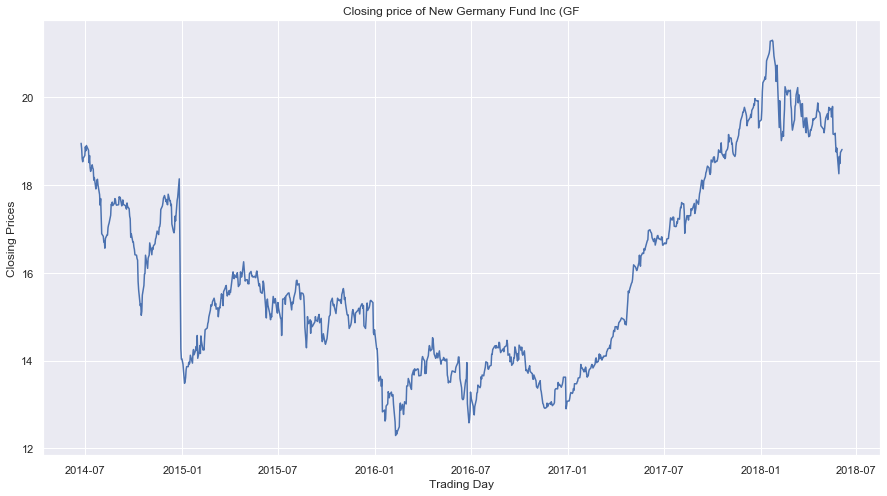

In [7]:
drop_cols = ['FIGI', 'TYPE', 'FREQUENCY', 'VOLUME', 'ADJ_OPEN', 'ADJ_HIGH',\
     'ADJ_LOW', 'ADJ_CLOSE', 'ADJ_VOLUME', 'ADJ_FACTOR', 'EX_DIVIDEND', 'SPLIT_RATIO']
data.drop(drop_cols, axis=1, inplace=True)
data.head()
# %% [markdown]
## Exploratory Data Analysis
# %%
sns.set()
sns.set_style('darkgrid')
plt.figure(figsize=(15,8))
plt.plot(data.CLOSE)
plt.title('Closing price of New Germany Fund Inc (GF')
plt.ylabel('Closing Prices')
plt.xlabel('Trading Day')
plt.show()

###### Moving Average

In [8]:
roll_mean = data.CLOSE.rolling(window=5).mean()
roll_mean

DATE
2018-06-04         NaN
2018-06-01         NaN
2018-05-31         NaN
2018-05-30         NaN
2018-05-29    18.58924
                ...   
2014-06-27    18.76602
2014-06-26    18.69202
2014-06-25    18.65602
2014-06-24    18.64802
2014-06-23    18.70400
Name: CLOSE, Length: 995, dtype: float64

In [9]:
def plot_moving_average(series, window, plot_intervals=False, scale=1.96):
    rolling_mean = series.rolling(window=window).mean()

    # calculate and plot rolliing mean
    plt.figure(figsize=(15,8))
    plt.title('Moving average\nwindow = {}'.format(window))
    plt.plot(rolling_mean, 'g', label='Rolling mean trend')

    # plot CI for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bound = rolling_mean - (mae + scale*deviation)
        upper_bound = rolling_mean + (mae + scale*deviation)
        plt.plot(upper_bound, 'r--', label='Upper bound / Lower bound')
        plt.plot(lower_bound, 'r--')
    plt.plot(series[window:], label='Actual values')
    plt.legend(loc='best')
    plt.grid(True)

###### Smooth by the previous 5 days (by week)

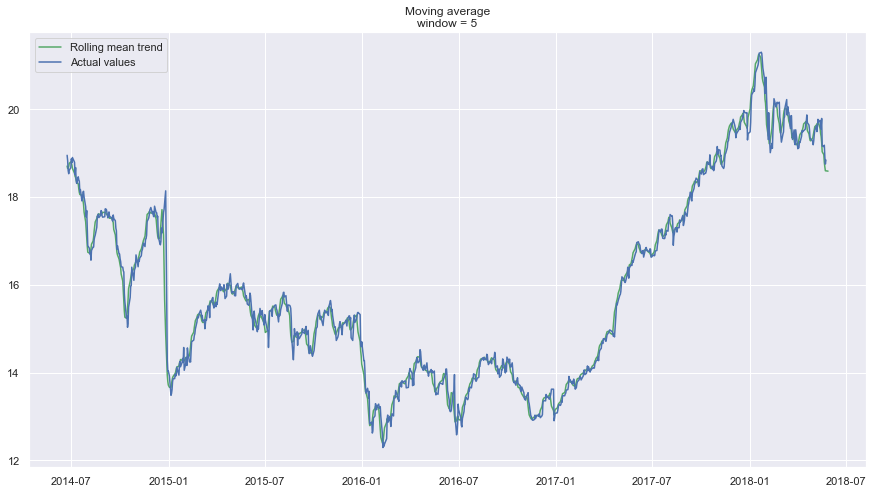

In [10]:
plot_moving_average(series=data.CLOSE, window=5)

###### Smooth by the previous 30 days (by month)

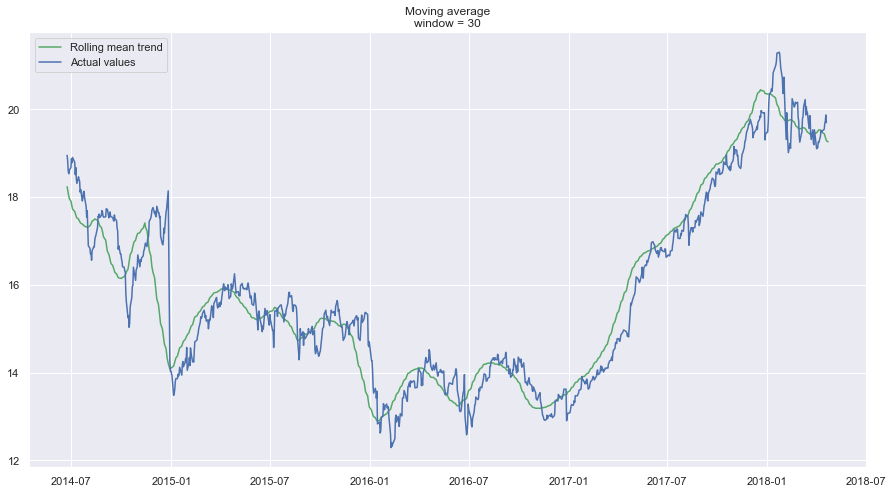

In [11]:
plot_moving_average(series=data.CLOSE, window=30)

###### Smooth by previous quarter (90 days)

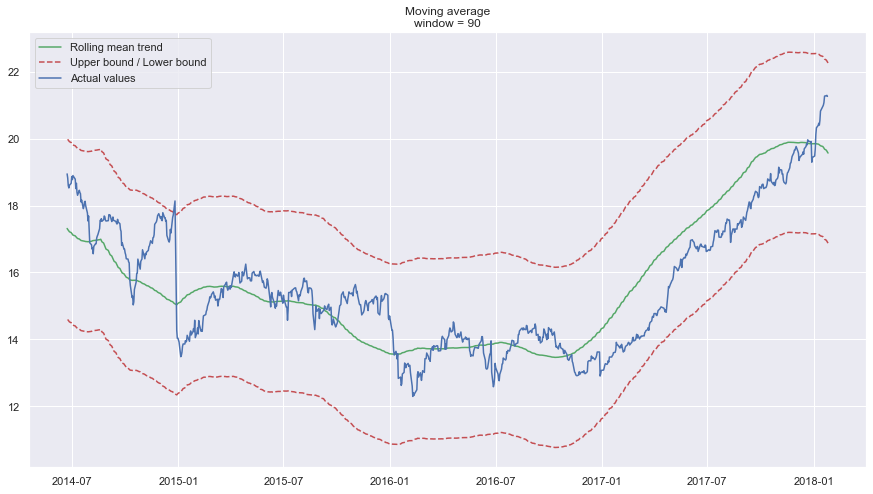

In [12]:
plot_moving_average(data.CLOSE, 90, plot_intervals=True)


## Exponential smoothing

In [13]:
def exponential_smoothing(series, alpha):
    result = [series[0]] # since first value is same as series
    for i in range(1, len(series)):
        result.append(alpha * series[i] + (1 - alpha) * result[i-1])
    return result

In [14]:
def plot_exponential_smoothing(series, alphas):
    plt.figure(figsize=(15,8))
    for alpha in alphas:
        plt.plot(exponential_smoothing(series, alpha), label='Alpha {}'.format(alpha))
    plt.plot(series.values, 'c', label='Actual')
    plt.legend(loc='best')
    plt.axis('tight')
    plt.title('Exponential Smoothing')
    plt.grid(True)
    

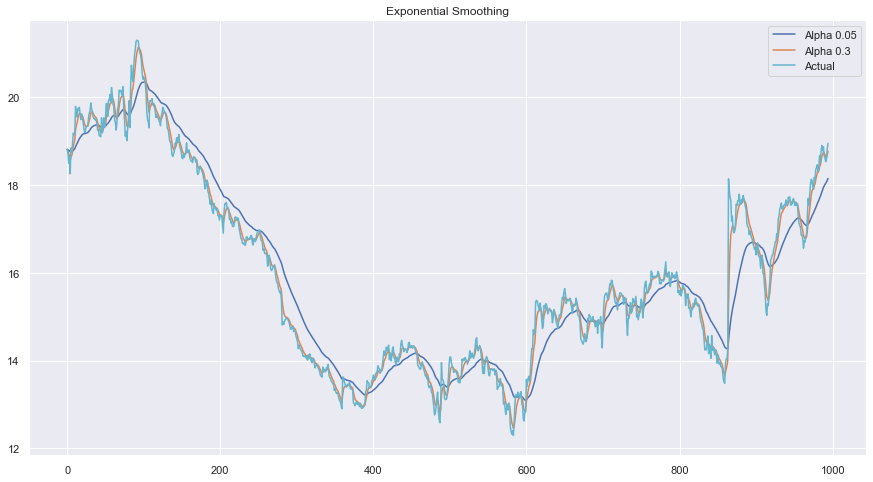

In [15]:
plot_exponential_smoothing(data.CLOSE, [0.05, 0.3])

## Double exponential smoothing

In [16]:
def double_exponential_smoothing(series, alpha, beta):
    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # forecasting
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha * value + (1 - alpha) * (level + trend)
        trend = beta * (level - last_level) + (1 - beta) * trend
        result.append(level + trend)
    return result

In [17]:
def plot_double_exponential_smoothing(series, alphas, betas):
     
    plt.figure(figsize=(17, 8))
    for alpha in alphas:
        for beta in betas:
            plt.plot(double_exponential_smoothing(series, alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
    plt.plot(series.values, label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Double Exponential Smoothing")
    plt.grid(True)

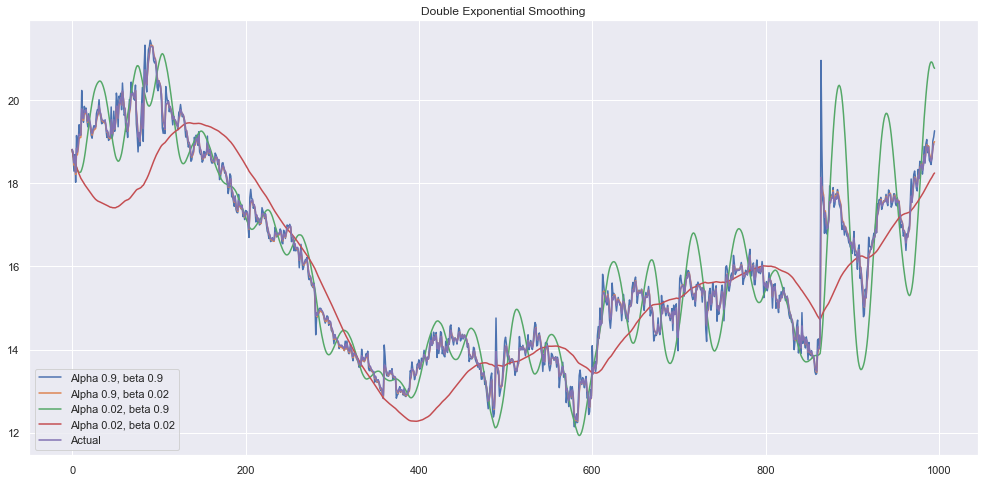

In [18]:
plot_double_exponential_smoothing(data.CLOSE, alphas=[0.9, 0.02], betas=[0.9, 0.02])

## Stationarity

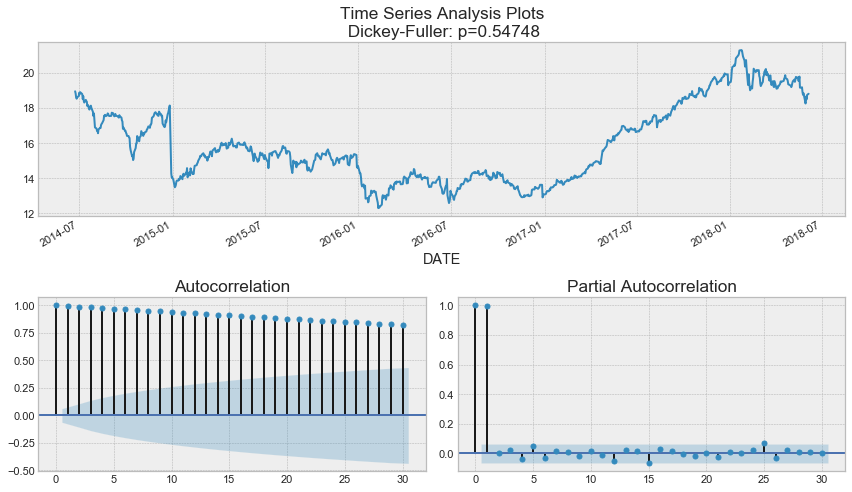

In [19]:
def tsplot(y, lags=None, figsize=(12, 7), syle='bmh'):
    
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style='bmh'):
        fig = plt.figure(figsize=figsize)
        layout = (2,2)
        ts_ax = plt.subplot2grid(layout, (0,0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1,0))
        pacf_ax = plt.subplot2grid(layout, (1,1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()
        
tsplot(data.CLOSE, lags=30)

In [20]:
data_diff = data.CLOSE - data.CLOSE.shift(1)

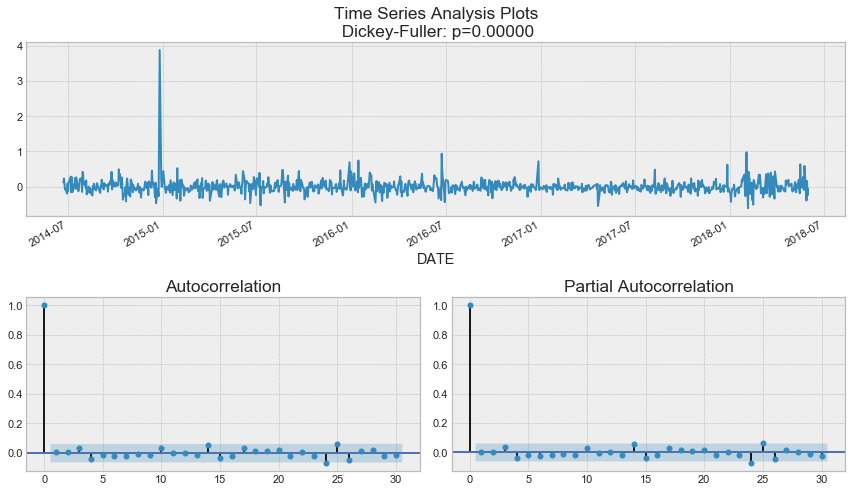

In [21]:
tsplot(data_diff[1:], lags=30)

## SARIMA

###### get initial values and some bounds

In [22]:
ps = range(0, 5)
d = 1
qs = range(0, 5)
Ps = range(0, 5)
D = 1
Qs = range(0, 5)
s = 5

###### create a list with all possible combinations of parameters

In [23]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

625

In [24]:
def optimize_SARIMA(parameters_list, d, D, s):
    """
        Return dataframe with parameters and corresponding AIC
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order
        D - seasonal integration order
        s - length of season
    """
    
    results = []
    best_aic = float('inf')
    
    for param in notebook.tqdm(parameters_list):
        try: model = sm.tsa.statespace.SARIMAX(data.CLOSE, order=(param[0], d, param[1]),
                                               seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
            
        aic = model.aic
        
        #Save best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])
        
    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    #Sort in ascending order, lower AIC is better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table

In [ ]:
%%timeit
result_table = optimize_SARIMA(parameters_list, d, D, s)

###### get parameters that give the lowest AIC (Akaike Information Criteria)

In [ ]:
p, q, P, Q = result_table.parameters[0]

In [ ]:
best_model = sm.tsa.statespace.SARIMAX(data.CLOSE, order=(p, d, q),
                                       seasonal_order=(P, D, Q, s)).fit(disp=-1)

In [ ]:
print(best_model.summary())

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
def plot_SARIMA(series, model, n_steps):
    """
        Plot model vs predicted values
        
        series - dataset with time series
        model - fitted SARIMA model
        n_steps - number of steps to predict in the future
    """
    
    data = series.copy().rename(columns = {'CLOSE': 'actual'})
    data['arima_model'] = model.fittedvalues
    #Make a shift on s+d steps, because these values were unobserved by the model due to the differentiating
    data['arima_model'][:s+d] = np.NaN
    
    #Forecast on n_steps forward
    forecast = model.predict(start=data.shape[0], end=data.shape[0] + n_steps)
    forecast = data.arima_model.append(forecast)
    #Calculate error
    error = mean_absolute_percentage_error(data['actual'][s+d:], data['arima_model'][s+d:])
    
    plt.figure(figsize=(17, 8))
    plt.title('Mean Absolute Percentage Error: {0:.2f}%'.format(error))
    plt.plot(forecast, color='r', label='model')
    plt.axvspan(data.index[-1], forecast.index[-1],alpha=0.5, color='lightgrey')
    plt.plot(data, label='actual')
    plt.legend()
    plt.grid(True);
    
# plot_SARIMA(data, best_model, 5)
print(best_model.predict(start=data.CLOSE.shape[0], end=data.CLOSE.shape[0] + 5))
print(mean_absolute_percentage_error(data.CLOSE[s+d:], best_model.fittedvalues[s+d:]))

In [ ]:
comparison = pd.DataFrame({'actual': [18.93, 19.23, 19.08, 19.17, 19.11, 19.12],
                          'predicted': [18.96, 18.97, 18.96, 18.92, 18.94, 18.92]}, 
                          index = pd.date_range(start='2018-06-05', periods=6,))
comparison.head()

In [ ]:
plt.figure(figsize=(15, 8))
plt.plot(comparison.actual)
plt.plot(comparison.predicted)
plt.title('Predicted closing price of New Germany Fund Inc (GF)')
plt.ylabel('Closing price ($)')
plt.xlabel('Trading day')
plt.legend(loc='best')
plt.grid(False)
plt.show()